In [2]:
import os
import sys

In [3]:
os.getcwd()
sys.path.append("../rfgi")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

from CARTGV_trees import DecisionCARTGVTreeClassifier, DecisionCARTGVTreeRegressor
from RFGV import RFGVClassifier, RFGVRegressor

from sklearn.utils.validation import check_random_state
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The package rfgi is inspired by the modules tree and random forest of Scikit-learn. Here are the links to the documentation :

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Example 1 : Iris dataset and multi-classes classification

In this section we will have a simple example of the package. We will use the Iris dataset in a multi-classes classification problem.

## Data

We first load our data and create our groups.

In [5]:
#Loading of the data
data = load_iris()

X = data.data
y= data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[0,1],[2,3],[0,2],[1,3]])

Here is the format of the groups

In [6]:
print(groups)

[[0 1]
 [2 3]
 [0 2]
 [1 3]]


As you can see above, the groups are defined as array containing the indexes of the variables. One variables can be in multiple groups. 

In this example the groups were set by grouping the variables about the Sepal together, the Petal together and a mix with Sepal and Petal length and Sepal and Petal width.

In [7]:
data = load_iris(as_frame=True)
data.data.join(data.target).head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


Here we can see the first 10 row of the dataset. If we take our group, the index 0 reference the variable "Sepal length", the index 1 the variable "Sepal width" etc. The target represent the class of the observation.

## Data representation

We will now represent our datas, what compose our dataset and what we want to predict.

In [8]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

<ipython-input-9-432b36512c3e>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


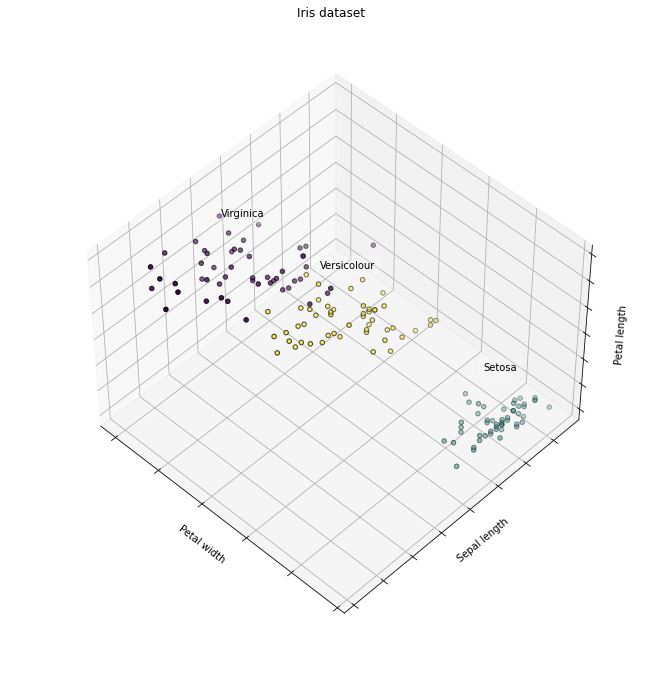

In [9]:
# Plot the data
fig = plt.figure(0, figsize=(16, 9))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y_reordered = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y_reordered, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Iris dataset')
ax.dist = 12

fig.show()

On the figure above we can see the Iris dataset and it's representation.

We can see 3 of the 4 variables which are Petal Length, Sepal length, Petal Width and Sepal Width.

We can also see that the dataset is composed of 3 classes, Virginica, Versicolour and Setosa.

Moreover, in this representation, we can see an important variable, Petal Width, that will split the dataset in the correct classes. We will later compare it to our result.

## Parameters

We will now define our parameter for our tree construction.

In [10]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

min_samples_leaf = 1 # The minimum number of observations in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
random_state = 2547 # # An int, the seed to fix the randomness (default=None, the randomness isn't fixed)
                            # Controls both the randomness of the bootstrapping of the samples used when building trees 
                            # (if bootstrap=True) and the sampling of the features to consider when looking for the best
                            # split at each node
max_depth = None # The maximal depth for the CARTGV tree
max_depth_splitting_tree = 2 # The maximal depth of splitting trees
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
pen = None # The penality function
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
max_features=None #  An int, not used anymore
max_leaf_nodes=None # An int, the maximum number of leaf the tree will be restricted to (default=None, No restrictions)
class_weight=None # A dict, list of dict, or "balanced", The class associated weights
ccp_alpha=0.0     # A non-negative float, the complexity parameter used for tree pruning

## Objects construction

We create here the object that will represent our tree. We use our previous parameters to define how our tree will be constructed. 

Important to note, if we have max_depth_splitting_tree = 1 and our groups are composed only of one variable each and one for each variable, we will create a CART tree such as the DecisionTreeClassifier of Scikit-learn.

In [11]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            pen = pen,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = None,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

## Tree construction

We construct our tree with our training datas and groups. After this our model will be trained and we will be able to predict, compute our classification score.

In [12]:
cartgvtreeclassifier.fit(X_train, y_train, groups)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


DecisionCARTGVTreeClassifier(mgroup=4, min_impurity_split=0.0,
                             mvar=array([2, 2, 2, 2]), random_state=2547)

## Classification score

Here we compute our classification score with our test datas. It represent the rate of good classification.

In [13]:
cartgvtreeclassifier.score(X_test, y_test)

0.96

We can see here a score of 0.96, it means that 96% of the datas are classed correctly. Our tree/model has a good predictive ability for those datas.

## Confusion matrix

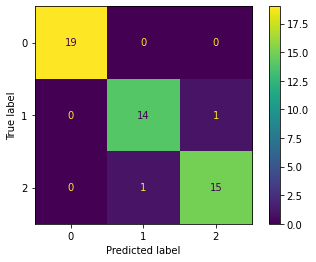

In [14]:
cm = confusion_matrix(y_test, cartgvtreeclassifier.predict(X_test))
cm_display = ConfusionMatrixDisplay(cm).plot()

The confusion matrix help us in evaluating the accuracy of the classification. When there is a value X outside of the diagonal, it means that X observations have been missclassed.

Here we can see the value 1 at the intersection between the class 1 and the class 2. Our tree missclassed 1 observation as a class 1 instead of class 2 and 1 observation as class 2 instead of class 1.

# Results and visualisation

We can, in this section, see much more information about our tree. We will be able to see the impurity in each node, the number of samples, the group used to split and even the splitting tree will be shown in a plot.

## Parents
Each number represent the parent of the node with the id the index in the array.
The parent -2 represent the root. 

Here the root has been split into 3 children, we can see that by the number of 0 in the array. It's children are the nodes with id : 1, 5 and 14.

In [15]:
print(cartgvtreeclassifier.tree_.nodes_parent)

[-2.  0.  1.  1.  1.  0.  5.  5.  7.  7.  5. 10. 10. 10.  0.]


## Impurities
Each value is the value of the node with the id the index in the array For example, the root of id 0 has for impurity 0.6658. We can see that this impurity decrease throughout the nodes, meaning that we found correct way to split our nodes.

In [16]:
print(cartgvtreeclassifier.tree_.nodes_impurities)

[0.6658     0.06243496 0.         0.         0.         0.18836565
 0.         0.5        0.         0.         0.05709343 0.
 0.         0.         0.        ]


The impurity is computed using the Gini criterion.

## Number of samples in each node
This array help us see the number of samples in each node. We started with 100 observations that were splitted in different node until we considered the node was a leaf.

In [17]:
print(cartgvtreeclassifier.tree_.nodes_n_node_samples)
print('\n')
print(cartgvtreeclassifier.tree_.nodes_weighted_n_node_samples)

[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


## Groups
Represent the group that splited the node.
A value of -1 means the node is a leaf and wasn't splitted. Here the root was splitted using the second group and its first child of id 1 has been splitted using the second group.

In [18]:
print(cartgvtreeclassifier.tree_.nodes_group)

[ 1.  2. -2. -2. -2.  1. -2.  1. -2. -2.  3. -2. -2. -2. -2.]


## Number of children
This array give us the number of children of each node. The root here has 3 children. These informations can also be found with the parent array.

In [19]:
print(cartgvtreeclassifier.tree_.nodes_n_childs)

[3. 3. 0. 0. 0. 3. 0. 2. 0. 0. 3. 0. 0. 0. 0.]


We can see that compared to a CART tree, a node can be splitted into more thant 2 children. It is the result of our splitting on group instead of variables and the use of splitting trees.

## Number of nodes in the CARTGVTree

In [20]:
print(cartgvtreeclassifier.tree_.node_count)

15


## Splitting trees
Here are the splitting trees in order of node id. The first one is the splitting tree of the root for example.

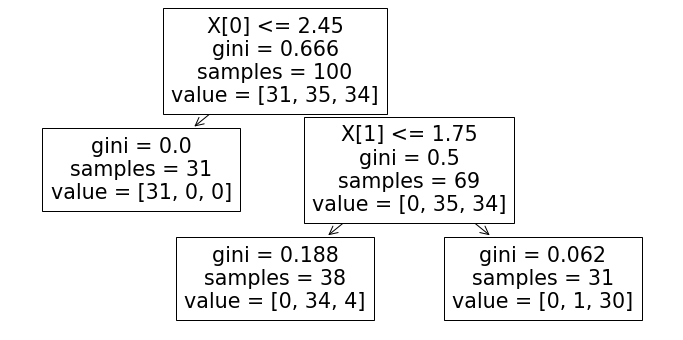

In [21]:
clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, max_features=len(groups[0]),
                             max_leaf_nodes=X.shape[0])

clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[0]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

# An example to plot all the splitting trees of the CARTGV tree
# for i in range(cartgvtreeclassifier.tree_.node_count):
#     clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[i]
#     if(cartgvtreeclassifier.tree_.nodes_splitting_trees[i] != None):
#         fig, ax = plt.subplots(1, figsize=(12, 6))
#         plot_tree(clf)
#         plt.show()

Here we have the splitting tree of the root of the tree. Just like we parametered, the splitting tree has a depth of 2. This tree has 3 leaves that will be the children of the node just like we saw previously in the children array.

We can also see the reparition of the samples in each class and child node. The left most child has an impurity of 0.0 (gini = 0.0) meaning the node contains only the same class. This child will be a leaf in the final CARTGV tree.

It is also important to remark the variable of the group used to split the node in the splitting tree. The first node was splitted using the first variable of the group, then the second split used the second variable.

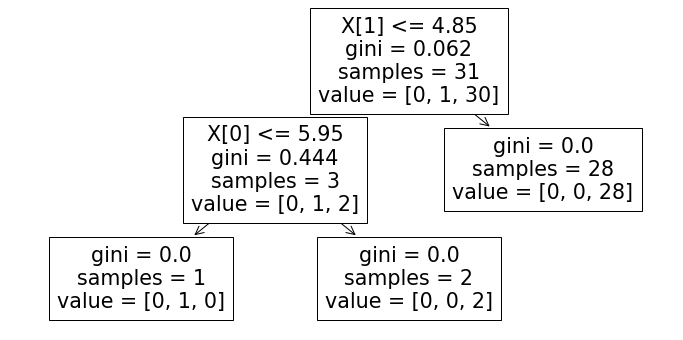

In [22]:
clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[1]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

We have here the splitting tree of the first child of the root (The right most leaf). On this splitting tree we can see 3 leaves with an impurity of 0.0. 

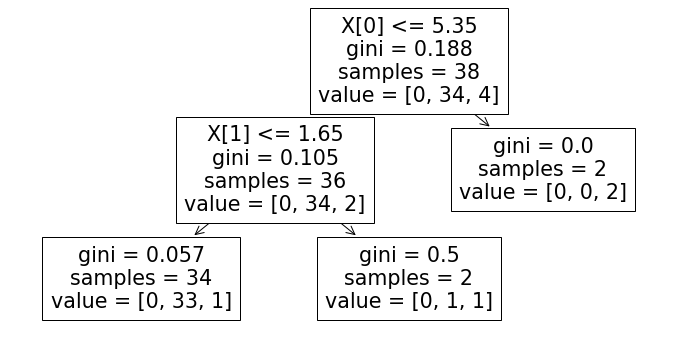

In [23]:
clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[5]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

We have here the splitting tree of the second child of the root (middle leaf). Here we do not have all leaves at an impurity=0.0. The process will continue until we only have leaves. In our example a leaf mean having an impurity of 0.0, but the stopping criterion can be changed with different parameters.

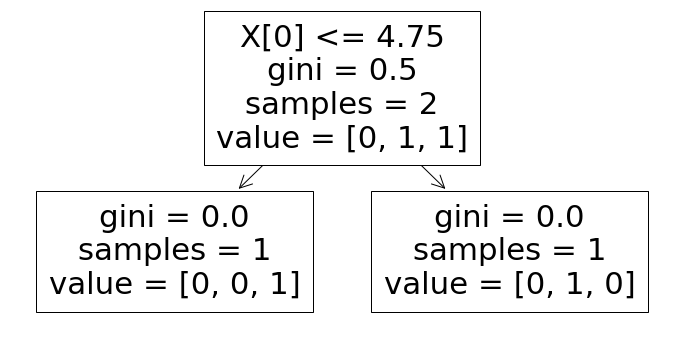

In [24]:
clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[7]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

Just like we said above, our splitting tree had leave with an impurity above 0.0, we had to split them again. Here is the splitting tree of the middle leaf with an impurity of 0.5 that we split to obtain two nodes leaves with impurity of 0.0.

## Forest

In [25]:
n_estimators=100            # An int, the number of trees that will be created
criterion="gini"            # A string, the criterion name that will be used to construct the forest
splitter="best"             # A string, the splitter name that will be used to construct the forest. 
                            # The strategy used to choose the split at each node. 
                            # Supported strategies is “best” to choose the best split
max_depth=None              # An int, the maximum depth of the tree, (default = None, construct the maximal tree)
max_depth_splitting_tree=2  # An int, the maximal depth of the splitting trees
min_samples_split=2         # An int, the minimal number of observations in a node needed to split it
min_samples_leaf=1          # An int, the minimal number under which the nodes are considered leaves
min_weight_fraction_leaf=0. # An int, the minimal weigth in a node under which it is considered a leaf. 
                            # The minimum weighted fraction of the sum total of weights (of all the input samples) required
                            # to be at a leaf node.
mvar="root"                 # An string or array/list, The number of variable that will be used 
                            # to construct the splitting trees for each group
mgroup=None                 # An int, the number of group that will be tested to find the best splitting tree
                            # (default = None, Use all the groups)
pen=None                    # A function with one parameter or a string ("root", "size", "log"), The penality function
                            # on the group size for the impurity calculation (default = None, No penality)
max_leaf_nodes=None         # An int, the maximum number of leaf the tree will be restricted to (default = None, No restriction)
min_impurity_decrease=0.    # A float, The value under which the decrease in impurity of a split need to be to split a node
min_impurity_split=None     # A float, The minimal value of impurity under which the node is considered a leaf (default=None)
bootstrap=True              # A boolean, If true the forest will use the bootstrap method
oob_score=False             # A boolean, If true the forest will compute the out-of-bag score
ib_score=False              # A boolean, If true, the forest will compute the in-bag score
n_jobs=None                 # An int, the number of process, threads that will be used to create the forest
random_state=None           # An int, the seed to fix the randomness (default=None, the randomness isn't fixed)
                            # Controls both the randomness of the bootstrapping of the samples used when building trees 
                            # (if bootstrap=True) and the sampling of the features to consider when looking for the best
                            # split at each node
verbose=0                   # An int, If verbose > 0 It will print the stepts of the forest
warm_start=False            # A boolean, Reuse the solution of the previous fit and add more estimators. 
                            # When set to True, reuse the solution of the previous call to fit and add more estimators
                            # to the ensemble, otherwise, just fit a whole new forest. 
class_weight=None           # A dict, list of dict, or "balanced", The class associated weights
ccp_alpha=0.0               # A non-negative float, the complexity parameter used for tree pruning
max_samples=None            # An int, The number of samples to draw from the data to train each estimator
random=True                 # A boolean, Remove the randomness in the forest

In [26]:
rfgv = RFGVClassifier(n_jobs=n_jobs, 
                      n_estimators=n_estimators, 
                      mvar=mvar, 
                      mgroup=len(groups)/3, 
                      max_depth_splitting_tree=max_depth_splitting_tree, 
                      random_state=2547, 
                      verbose=0,
                      criterion="gini",
                      splitter="best",
                      max_depth=None,
                      min_samples_split=2,
                      min_samples_leaf=1,
                      min_weight_fraction_leaf=0.0,
                      pen=None,
                      max_leaf_nodes=None,
                      min_impurity_decrease=0.,
                      min_impurity_split=None,
                      bootstrap=True,
                      oob_score=False,
                      ib_score=False,
                      warm_start=False,
                      class_weight=None,
                      ccp_alpha=0.0,
                      max_samples=None,
                      random=True) #verbose >1 for text

In [27]:
rfgv.fit(X_train, y_train, groups)

RFGVClassifier(mgroup=1.3333333333333333, random_state=2547, splitter=('best',))

In [28]:
rfgv.score(X_test, y_test)

0.98

We can here compare the score of a forest to a tree. We can see that the forest has a score of good prediction of 0.98 when the tree had a score of 0.96. The number of estimator and the randomness used in the forest help us reduce the over-fitting, which help us having better scores in the end.

# Example 2 : Diabetes dataset and regression

In [29]:
#Loading of the data
data = load_diabetes()
X = data.data
y = data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
groups = np.array([[2,9],[5,6],[0,1,2],[7,8],[4,8]], dtype=object)

In [30]:
print(groups)

[list([2, 9]) list([5, 6]) list([0, 1, 2]) list([7, 8]) list([4, 8])]


In [31]:
df = load_diabetes(as_frame=True)
df.data.join(df.target).head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504,310.0


In [32]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

## Parameters

In [33]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
random_state = 2547 # An int, the seed to fix the randomness (default=None, the randomness isn't fixed)
                            # Controls both the randomness of the bootstrapping of the samples used when building trees 
                            # (if bootstrap=True) and the sampling of the features to consider when looking for the best
                            # split at each node# The seed
max_depth = None # The maximal depth for the CARTGV tree (default=None, create a maximal tree)
max_depth_splitting_tree = 2 # The maximal depth for the splitting trees
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
pen = None # The penality function
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
max_features=None #  An int, not used anymore
max_leaf_nodes=None # An int, the maximum number of leaf the tree will be restricted to (default=None, no restrictions)
ccp_alpha=0.0     # A non-negative float, the complexity parameter used for tree pruning

## Object construction

Just like the first example we create here the object that will represent our tree. We use our previous parameters to define how our tree will be constructed.

Important to note, if we have max_depth_splitting_tree = 1 and our groups are composed only of one variable each and one for each variable, we will create a CART tree such as the DecisionTreeRegressor of Scikit-learn.

In [34]:
cartgvtreeregressor = DecisionCARTGVTreeRegressor(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            pen=pen,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = None,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            ccp_alpha=0.0)

## Tree construction

We construct our tree with our training datas and groups. After this our model will be trained and we will be able to predict, compute our classification score.

In [35]:
cartgvtreeregressor.fit(X_train, y_train, groups)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


DecisionCARTGVTreeRegressor(mgroup=5, min_impurity_split=0.0,
                            mvar=array([2, 2, 3, 2, 2]), random_state=2547)

## Regression score

In [36]:
cartgvtreeregressor.score(X_test, y_test)

-0.1802735135367779

### Scikit-learn Regression tree and score

Link to the documentation :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [37]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train) # Train the tree
reg.score(X_test, y_test) # Get the prediction score

-0.16604114864860464

With a negative score, we have a really poor model and prediction. We can compare it to Scikit-learn DecisionTreeRegressor that did a just a bit better than us.

## Result and visualisation
In this section only the informations about the first 50 nodes of the CARTGV tree will be shown as there's too much of them.

### Parents
It works the same way as the previous example. Each number represent the parent of the node with the id the index in the array.
The parent -2 represent the root.

In [38]:
print(cartgvtreeregressor.tree_.nodes_parent[:50])

[-2.  0.  1.  2.  2.  2.  5.  5.  2.  8.  8.  1.  1. 12. 12. 12. 12.  1.
 17. 18. 18. 17. 21. 21. 21. 17. 25. 25. 25. 17. 29. 29.  0. 32. 33. 34.
 34. 36. 36. 34. 39. 39. 34. 42. 42. 42. 33. 46. 46. 48.]


We cannot say how many children each node has because only the first 50 nodes are presented, but we still can see that our tree create more than 2 children for a node. if we take for example the 2nd node, we can see 3 node having the node of id=2.

### Impurities
Each value is the value of the node with the id the index in the array For example, the root of id 0 has for impurity 6015. We can see that this impurity decrease throughout the nodes, meaning that we found correct way to split our nodes.

In [39]:
print(cartgvtreeregressor.tree_.nodes_impurities[:50])

[6.01594904e+03 2.79756198e+03 1.85580556e+03 0.00000000e+00
 0.00000000e+00 2.50000000e+01 0.00000000e+00 0.00000000e+00
 1.00000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.86875000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.18000000e+02 1.00000000e+00 0.00000000e+00
 0.00000000e+00 4.27500000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.46666667e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+02 0.00000000e+00 0.00000000e+00
 4.25725961e+03 1.63768359e+03 3.98609375e+02 0.00000000e+00
 2.25000000e+00 0.00000000e+00 0.00000000e+00 9.00000000e+00
 0.00000000e+00 0.00000000e+00 7.35555556e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.57142857e+02 0.00000000e+00
 2.50000000e-01 0.00000000e+00]


These impurities are computed with the MSE criterion (Mean Square Error).

### Number of samples in each nodes
This array help us see the number of samples in each node. We started with 296 observations that were splitted in different node until we considered the node was a leaf.

In [40]:
print(cartgvtreeregressor.tree_.nodes_n_node_samples[:50])
print('\n')
print(cartgvtreeregressor.tree_.nodes_weighted_n_node_samples[:50])

[296.  22.   6.   1.   1.   2.   1.   1.   2.   1.   1.   1.   4.   1.
   1.   1.   1.  11.   2.   1.   1.   4.   1.   1.   2.   3.   1.   1.
   1.   2.   1.   1.  87.  16.   8.   1.   2.   1.   1.   2.   1.   1.
   3.   1.   1.   1.   7.   1.   2.   1.]


[296.  22.   6.   1.   1.   2.   1.   1.   2.   1.   1.   1.   4.   1.
   1.   1.   1.  11.   2.   1.   1.   4.   1.   1.   2.   3.   1.   1.
   1.   2.   1.   1.  87.  16.   8.   1.   2.   1.   1.   2.   1.   1.
   3.   1.   1.   1.   7.   1.   2.   1.]


### Groups
Represent the group that splited the node. A value of -1 means the node is a leaf and wasn't splitted. Here the root was splitted using the first group and its first child of id 1 has been splitted using the second group.

In [41]:
print(cartgvtreeregressor.tree_.nodes_group[:50])

[ 0.  1.  0. -2. -2.  3. -2. -2.  2. -2. -2. -2.  0. -2. -2. -2. -2.  4.
  0. -2. -2.  0. -2. -2. -2.  1. -2. -2. -2.  1. -2. -2.  4.  1.  4. -2.
  2. -2. -2.  1. -2. -2.  2. -2. -2. -2.  2. -2.  0. -2.]


### Number of children
This array give us the number of children of each node.

In [42]:
print(cartgvtreeregressor.tree_.nodes_n_childs[:50])

[4. 4. 4. 0. 0. 2. 0. 0. 2. 0. 0. 0. 4. 0. 0. 0. 0. 4. 2. 0. 0. 3. 0. 0.
 0. 3. 0. 0. 0. 2. 0. 0. 4. 3. 4. 0. 2. 0. 0. 2. 0. 0. 3. 0. 0. 0. 4. 0.
 2. 0.]


### Number of nodes in the tree

In [43]:
print(cartgvtreeregressor.tree_.node_count)

433


### Splitting trees
Here are the splitting trees in order of node id. The first one is the splitting tree of the root for example. Only the splitting trees of the first ten nodes are presented. 

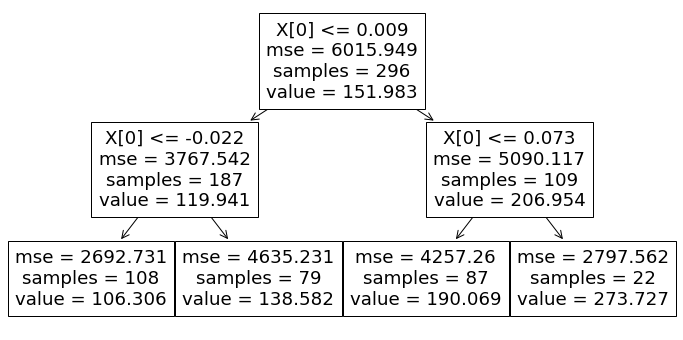

In [44]:
clf = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state, max_features=len(groups[0]),
                             max_leaf_nodes=X.shape[0])
                                                    
clf.tree_ = cartgvtreeregressor.tree_.nodes_splitting_trees[0]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

Here we have the splitting tree of the root of the tree. Just like we parametered, the splitting tree has a depth of 2. This tree has 4 leaves that will be the children of the node.

We can also see mean value in the nodes. For example the most right leaf has a mean value of 273.727. We can also see the impurity (mse), the goal is to decrease this impurity in the children node.

It is also important to remark the variable of the group used to split the node in the splitting tree. The first node was splitted using the first variable of the group the same as the two other splits.

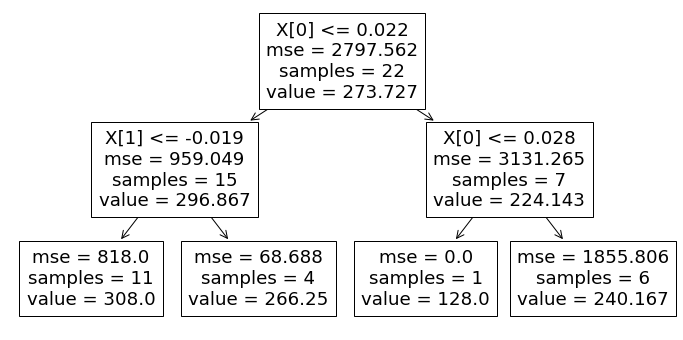

In [45]:
clf.tree_ = cartgvtreeregressor.tree_.nodes_splitting_trees[1]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

We have here the splitting tree of the first child of the root (The most right leaf). On this splitting tree we can see 4 leaves with one wth an impurity of 0. In a regression problem, a node can be considered a leaf if there's less or equal to 5 samples in the node. Here we can see 2 leaves, at the center.

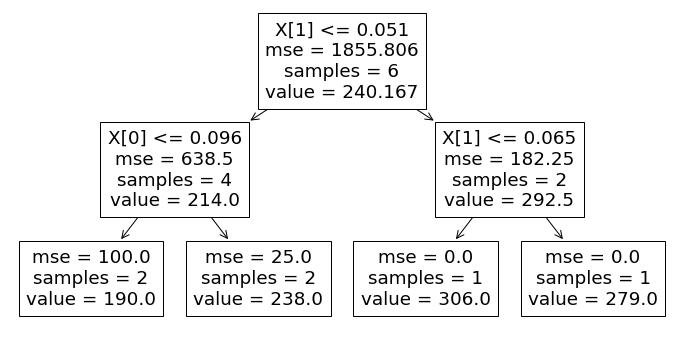

In [46]:
clf.tree_ = cartgvtreeregressor.tree_.nodes_splitting_trees[2]
fig, ax = plt.subplots(1, figsize=(12, 6))
plot_tree(clf)
plt.show()

Here is the splitting tree of the right leaf with an impurity of 1855.806 that we split to obtain 4 nodes leaves a number of samples under 5. We can see here the value that will be predicted in those leaves with the value line.

## Forest

In [47]:
n_estimators=100            # An int, the number of trees that will be created
criterion="mse"            # A string, the criterion name that will be used to construct the forest
splitter="best"             # A string, the splitter name that will be used to construct the forest
max_depth=None              # An int, the maximum depth of the trees
max_depth_splitting_tree=2  # An int, the maximal depth of the splitting trees
min_samples_split=2         # An int, the minimal number of samples in a node needed to split it
min_samples_leaf=1          # An int, the minimal number under which the nodes are considered leaves
min_weight_fraction_leaf=0. # An int, the minimal weigth in a node under which it is considered a leaf
mvar="root"                 # An string or array/list, The number of variable that will be used 
                            # to construct the splitting trees for each group
mgroup=None                 # An int, the number of group that will be tested to find the best splitting tree
pen=None                    # A function with one parameter or a string ("root", "size", "log"), The penality function
                            # on the group size for the impurity calculation
max_leaf_nodes=None         # An int, the maximum number of leaf the tree will be restricted to
min_impurity_decrease=0.    # A float, The value under which the decrease in impurity of a split need to be to split a node
min_impurity_split=None     # A float, The minimal value of impurity under which the node is considered a leaf
bootstrap=True              # A boolean, If true the forest will use the bootstrap method
oob_score=False             # A boolean, If true the forest will compute the out-of-bag score
ib_score=False              # A boolean, If true, the forest will compute the in-bag score
n_jobs=None                 # An int, the number of process, threads that will be used to create the forest
random_state=None           # An int, the seed to fix the randomness
verbose=0                   # An int, If verbose > 0 It will print the stepts of the forest
warm_start=False            # A boolean, Reuse the solution of the previous fit and add more estimators
ccp_alpha=0.0               # A non-negative float, the complexity parameter used for tree pruning
max_samples=None            # An int, The number of samples to draw from the data to train each estimator
random=True                 #  A boolean, Remove the randomness in the forest

In [48]:
rfgv = RFGVRegressor(n_jobs=n_jobs, 
                      n_estimators=n_estimators, 
                      mvar=mvar, 
                      mgroup=len(groups)/3, 
                      max_depth_splitting_tree=max_depth_splitting_tree, 
                      random_state=2547, 
                      verbose=0,
                      criterion="mse",
                      splitter="best",
                      max_depth=None,
                      min_samples_split=2,
                      min_samples_leaf=1,
                      min_weight_fraction_leaf=0.0,
                      pen=None,
                      max_leaf_nodes=None,
                      min_impurity_decrease=0.,
                      min_impurity_split=None,
                      bootstrap=True,
                      oob_score=False,
                      ib_score=False,
                      warm_start=False,
                      ccp_alpha=0.0,
                      max_samples=None,
                      random=True) #verbose >1 for text

In [49]:
rfgv.fit(X_train, y_train, groups)

RFGVRegressor(mgroup=1.6666666666666667, mvar='root', random_state=2547,
              splitter=('best',))

In [50]:
rfgv.score(X_test, y_test)

0.4954095157579165

We can here compare the score of a forest to a tree. We can see a huge difference with the forest having a score of ~85% instead of the ~-18% of the tree. The number of estimator and the randomness used in the forest helped us in reducing the over-fitting, which helped us having better scores in the end.

# Example 3 : Breast cancer dataset and binary classification

## Data

In [51]:
#Loading of the data
data = load_breast_cancer()

X = data.data
y= data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

groups = np.array([[0,2,3,10,12,13,20,22,23],[1,4,5,11,14,15,21,24,25],[6,7,16,17,26,27],[8,9,18,19,28,29]], dtype=object)

In [52]:
df = load_breast_cancer(as_frame=True)
df.data.join(df.target).head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In [53]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## Parameters

In [54]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
random_state = 2547 # The seed
max_depth = None # The maximal depth for the splitting_tree
max_depth_splitting_tree = 2
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit,
pen=None # The penality function
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
max_features=None #  An int, the maximum number of leaf the tree will be restricted to
max_leaf_nodes=None # An int, the maximum number of leaf the tree will be restricted to
class_weight=None # A dict, list of dict, or "balanced", The class associated weights
ccp_alpha=0.0     # A non-negative float, the complexity parameter used for tree pruning

## Object construction

In [55]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            pen=pen,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = None,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

## Tree construction

In [56]:
cartgvtreeclassifier.fit(X_train, y_train, groups)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


DecisionCARTGVTreeClassifier(mgroup=4, min_impurity_split=0.0,
                             mvar=array([9, 9, 6, 6]), random_state=2547)

## Classification score

In [57]:
cartgvtreeclassifier.score(X_test, y_test)

0.9095744680851063

The rate of good classification of our tree is of ~90%.

## Pruning

In [58]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
random_state = None # The seed
max_depth = None # The maximal depth for the CARTGV tree
max_depth_splitting_tree = 2 # The maximal depth of the splitting trees
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
max_features=None #  An int, not used anymore
max_leaf_nodes=None # An int, the maximum number of leaf the tree will be restricted to
class_weight=None # A dict, list of dict, or "balanced", The class associated weights
ccp_alpha=0.0     # A non-negative float, the complexity parameter used for tree pruning

### Max depth = 4

In [59]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = None,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

In [60]:
cartgvtreeclassifier.fit(X_train, y_train, groups)
cartgvtreeclassifier.score(X_val,y_val)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


0.9047619047619048

### Max depth = 3

In [61]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = 3,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

In [62]:
cartgvtreeclassifier.fit(X_train, y_train, groups)
cartgvtreeclassifier.score(X_val,y_val)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


0.873015873015873

### Max depth = 2

In [63]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = 2,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

In [64]:
cartgvtreeclassifier.fit(X_train, y_train, groups)
cartgvtreeclassifier.score(X_val,y_val)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


0.9126984126984127

### Max depth = 1

In [65]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = 1,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)

In [66]:
cartgvtreeclassifier.fit(X_train, y_train, groups)
cartgvtreeclassifier.score(X_val,y_val)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


0.9206349206349206

### Results

In [67]:
score_depth_4 = 0.9047619047619048
score_depth_3 = 0.8888888888888888
score_depth_2 = 0.9047619047619048
score_depth_1 = 0.9206349206349206

We can see here that the optimal tree is the tree with a depth of 1 with a score of ~92%.

### Score on test data of optimal tree

In [68]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree,
                            min_samples_leaf = 1, 
                            min_samples_split = 2, 
                            max_depth = 1,
                            min_impurity_decrease = 0.0,
                            min_impurity_split = 0.0,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            max_leaf_nodes=None,
                            class_weight=None,
                            ccp_alpha=0.0)
cartgvtreeclassifier.fit(X_train, y_train, groups)
cartgvtreeclassifier.score(X_test,y_test)

../rfgi\CARTGV_trees.py:308: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(


0.8829787234042553

The maximal tree with had a depth of 4 and a score of ~90% when the optimal tree had a score of ~88%.

# Example 4 : Breast cancer dataset and random forest classifier

## Parameters

In [69]:
n_estimators=100            # An int, the number of trees that will be created
criterion="gini"            # A string, the criterion name that will be used to construct the forest
splitter="best"             # A string, the splitter name that will be used to construct the forest
max_depth=None              # An int, the maximum depth of the trees
max_depth_splitting_tree=2  # An int, the maximal depth of the splitting trees
min_samples_split=2         # An int, the minimal number of samples in a node needed to split it
min_samples_leaf=1          # An int, the minimal number under which the nodes are considered leaves
min_weight_fraction_leaf=0. # An int, the minimal weigth in a node under which it is considered a leaf
mvar="root"                 # An string or array/list, The number of variable that will be used 
                            # to construct the splitting trees for each group
mgroup=None                 # An int, the number of group that will be tested to find the best splitting tree
pen=None                    # A function with one parameter or a string, The penality function
                            # on the group size for the impurity calculation
max_leaf_nodes=None         # An int, the maximum number of leaf the tree will be restricted to
min_impurity_decrease=0.    # A float, The value under which the decrease in impurity of a split need to be to split a node
min_impurity_split=None     # A float, The minimal value of impurity under which the node is considered a leaf
bootstrap=True              # A boolean, If true the forest will use the bootstrap method
oob_score=False             # A boolean, If true the forest will compute the out-of-bag score
ib_score=False              # A boolean, If true, the forest will compute the in-bag score
n_jobs=None                 # An int, the number of process, threads that will be used to create the forest
random_state=None           # An int, the seed to fix the randomness
verbose=0                   # An int, If verbose > 0 It will print the stepts of the forest
warm_start=False            # A boolean, Reuse the solution of the previous fit and add more estimators
class_weight=None           # A dict, list of dict, or "balanced", The class associated weights
ccp_alpha=0.0               # A non-negative float, the complexity parameter used for tree pruning
max_samples=None            # An int, The number of samples to draw from the data to train each estimator
random=True                 #  A boolean, Remove the randomness in the forest

## Object construction

In [70]:
rfgv = RFGVClassifier(n_jobs=n_jobs, 
                      n_estimators=n_estimators, 
                      mvar=mvar, 
                      mgroup=len(groups)/3, 
                      max_depth_splitting_tree=max_depth_splitting_tree, 
                      random_state=2547, 
                      verbose=0,
                      criterion="gini",
                      splitter="best",
                      max_depth=None,
                      min_samples_split=2,
                      min_samples_leaf=1,
                      min_weight_fraction_leaf=0.0,
                      pen=None,
                      max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_impurity_split=None,
                      bootstrap=True,
                      oob_score=False,
                      ib_score=False,
                      warm_start=False,
                      class_weight=None,
                      ccp_alpha=0.0,
                      max_samples=None,
                      random=True
                      ) #verbose >1 for text

## Forest construction

In [71]:
rfgv.fit(X_train, y_train, groups)

RFGVClassifier(mgroup=1.3333333333333333, random_state=2547, splitter=('best',))

## Forest classification score

In [72]:
rfgv.score(X_test,y_test)

0.9521276595744681

This score can be compared to the previous example score. We can see that just like the first example and the second example, we have an increase in accuracy in the score with ~95% here compared to ~92% for the optimal tree after pruning.

## Confusion matrix

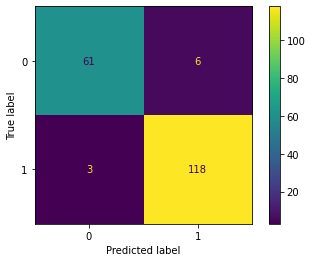

In [73]:
cm = confusion_matrix(y_test, rfgv.predict(X_test))
cm_display = ConfusionMatrixDisplay(cm).plot()

The confusion matrix help us in evaluating the accuracy of the classification. When there is a value X outside of the diagonal, it means that X observations have been missclassed.

Our tree missclassed 3 observations as a class 0 instead of class 1 and 4 observations as class 1 instead of class 0.

## Group importances

In [74]:
importances = rfgv._permutation_importance(importance="breiman", # A string, the method used to compute the importance ("breiman","ishwaran")
                             n_jobs=1, # An int, the number of process/threads used to compute (can't be more than 1 at the moment) 
                             n_repeats=5) # An int, the number of repetitions of the computation to obtain the mean, and std
print(importances)

{'importances_mean': array([0.24276666, 0.1475092 , 0.23512444, 0.11184604]), 'importances_std': array([0.00230556, 0.00036195, 0.00381619, 0.0015153 ]), 'importances': array([[0.24301617, 0.24056291, 0.2413057 , 0.24185769, 0.24709085],
       [0.1473626 , 0.14773773, 0.14699941, 0.14806219, 0.14738408],
       [0.23080604, 0.23257436, 0.23283572, 0.23920314, 0.24020292],
       [0.11238262, 0.1128974 , 0.1116686 , 0.10901227, 0.1132693 ]])}


The result of this method gives us the importance of each group in the decision making for the prediction. We mostly look at the mean of those values.

Here we can see that the first group was the most important, as his value is the highest. The next are the third group then, the second and to finish the fourth group.

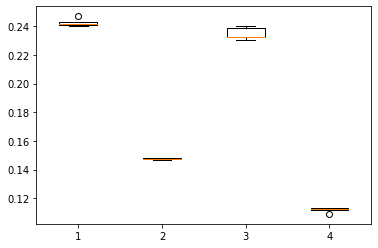

In [76]:
plt.boxplot(np.transpose(importances.importances))
plt.show()

This boxplot present the previous result. We can see the different importance of each variable, but the most important part is the order in which they are. We can clearly see the first variable being the highest, then the third followed by the second and finally by the fourth.